### Prepare

In [1]:
#coutils package
!pip install git+https://github.com/Mooozer/starterCode_-fromJohnson
import coutils
from coutils import fix_random_seed

  Cloning https://github.com/Mooozer/starterCode_-fromJohnson to /tmp/pip-req-build-g9ll1o68
  Running command git clone -q https://github.com/Mooozer/starterCode_-fromJohnson /tmp/pip-req-build-g9ll1o68
  Created wheel for Colab-Utils: filename=Colab_Utils-0.1.dev0-cp36-none-any.whl size=10324 sha256=8712448a820476e41c6681fab345c6b32526b72c289a3ddaaa7d47b41ff19c6d
  Stored in directory: /tmp/pip-ephem-wheel-cache-7z3ye8ci/wheels/33/99/25/c7b075b8e2708cf81105eb4209afcb8720adb16a42675822dc
Successfully built Colab-Utils


In [2]:
import numpy as np
import pandas as pd
from collections import OrderedDict
import math
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt

if torch.cuda.is_available:
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


In [3]:
# data type and device for torch.tensor
to_float = {'dtype': torch.float, 'device': 'cpu'}
to_float_cuda = {'dtype': torch.float, 'device': 'cuda'}
to_double = {'dtype': torch.double, 'device': 'cpu'}
to_double_cuda = {'dtype': torch.double, 'device': 'cuda'}
to_long = {'dtype': torch.long, 'device': 'cpu'}
to_long_cuda = {'dtype': torch.long, 'device': 'cuda'}

### Load Data

In [6]:
from google.colab import files
uploaded = files.upload()  #merged_sur_hrv_hr.csv  and  rrdata.csv

Saving rrdata.csv to rrdata.csv


In [8]:
rrdata = pd.read_csv('rrdata.csv')
data = pd.read_csv('merged_sur_hrv_hr.csv')

In [9]:
data['class4'] = [0 if i in (1.,2.) else 1 if i in (3.,) else 2 if i in (4.,) else 3 for i in data['S_COVID_OVERALL']] 
data['time_of_day'] = [1. if i=='morning' else 2. if i=='day' else 3. if i=='evening' else 4. for i in data['time_of_day']] 

data0 = data[['time_of_day', 'heart_rate', 'bpm', 'meanrr', 'mxdmn', 'sdnn',
       'rmssd', 'pnn50', 'mode', 'amo', 'lf', 'hf', 'vlf', 'lfhf',
       'total_power', 'day_after_test', 'S_COVID_BREATH', 'S_COVID_CONFUSION',
       'S_COVID_COUGH', 'S_COVID_FATIGUE', 'S_COVID_FEVER', 'S_COVID_PAIN',
       'S_COVID_BLUISH', 'class4']]
data1 = data[['time_of_day', 'bpm', 'meanrr', 'mxdmn', 'sdnn',
       'rmssd', 'pnn50', 'mode', 'amo', 'lf', 'hf', 'vlf', 'lfhf',
       'total_power', 'day_after_test', 'S_COVID_BREATH', 'S_COVID_CONFUSION',
       'S_COVID_COUGH', 'S_COVID_FATIGUE', 'S_COVID_FEVER', 'S_COVID_PAIN',
       'S_COVID_BLUISH', 'class4']]
data2 = data[['time_of_day', 'bpm', 'meanrr', 'mxdmn', 'sdnn',
       'rmssd', 'pnn50', 'mode', 'amo', 'lf', 'hf', 'vlf', 'lfhf',
       'total_power', 'day_after_test', 'class4']]

data3 = data[['bpm', 'meanrr', 'mxdmn', 'sdnn',
       'rmssd', 'pnn50', 'mode', 'amo', 'lf', 'hf', 'vlf', 'lfhf',
       'total_power', 'class4']]


### PCA

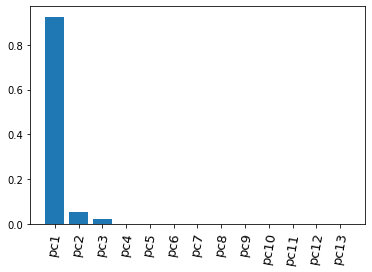

Cumulative sum of variance explained by PCs


array([0.92568087, 0.97840137, 0.99891366, 0.99955102, 0.99997677,
       0.99999199, 0.99999562, 0.9999977 , 0.99999881, 0.99999971,
       1.        , 1.        , 1.        ])

In [10]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(data3.drop('class4', axis=1))
var_explained_ratio = pca.explained_variance_ratio_ 

plt.bar(['pc'+str(i) for i in range(1,len(var_explained_ratio)+1)], var_explained_ratio)
plt.xticks(rotation=80,fontsize=13)
plt.show()
print("Cumulative sum of variance explained by PCs")
np.cumsum(var_explained_ratio)

Text(0, 0.5, 'component 2')

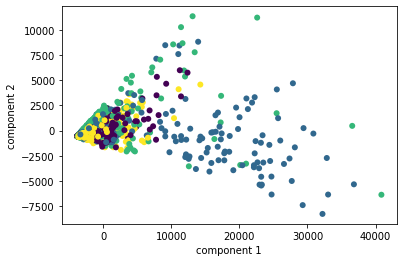

In [11]:
pca2 = PCA(n_components=2)
pca2.fit(data3.drop('class4', axis=1))
hrv_featurePCs = pd.DataFrame(data=pca2.transform(data3.drop('class4', axis=1)), columns=['pc1','pc2'])  

hrv_featurePCs['class4'] = data3['class4']
plt.scatter(hrv_featurePCs['pc1'], hrv_featurePCs['pc2'],c=hrv_featurePCs['class4'], edgecolor='none')
plt.xlabel('component 1')
plt.ylabel('component 2')

In [12]:
data4 = pd.concat([hrv_featurePCs, data1[['time_of_day','day_after_test', 'S_COVID_BREATH', 'S_COVID_CONFUSION',
       'S_COVID_COUGH', 'S_COVID_FATIGUE', 'S_COVID_FEVER', 'S_COVID_PAIN','S_COVID_BLUISH']]], axis=1)

### Point Data and Sequence Data

In [57]:
N, V, T, C= 1489, 11, 100, 4
Pointdata = torch.tensor(data1.drop(['class4'], axis=1).values).to(torch.float)  #(N=1489,  V=11)
Pointdata = Pointdata / Pointdata.max(0, keepdim=True).values    #Normalize 

Seqdata = torch.tensor(rrdata.drop(['user_code','time_of_day','S_COVID_OVERALL','day_after_test'],axis=1).values).to(torch.float)
Seqdata = Seqdata / Seqdata.max(0, keepdim=True).values #Normalize

Seqdata = Seqdata.reshape(N,T,1) #(N=1489,T=100,1)
class_y = torch.tensor(data1['class4'].values)  #(N=1489, )


print("Pointdata:", Pointdata.shape, Pointdata.dtype)
print("Seqdata:", Seqdata.shape, Seqdata.dtype)
print("class_y:", class_y.shape, class_y.dtype)



Pointdata: torch.Size([1489, 22]) torch.float32
Seqdata: torch.Size([1489, 100, 1]) torch.float32
class_y: torch.Size([1489]) torch.int64


### LSTM

In [58]:
def lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b, attn=None, Wattn=None):
    """
    Forward pass for a single timestep of an LSTM.

    The input data has dimension D(number of sequences is D), the hidden state has dimension H=1, and we use
    a minibatch size of N.

    Inputs:
    - x: Input data, of shape (N, D)
    - prev_h: Previous hidden state, of shape (N, H=1)
    - prev_c: previous cell state, of shape (N, H=1)
    - Wx: Input-to-hidden weights, of shape (D, 4H=4)
    - Wh: Hidden-to-hidden weights, of shape (H=1, 4H=4)
    - b: Biases, of shape (4H=4,)      
    
    Returns a tuple of:
    - next_h: Next hidden state, of shape (N, H)
    - next_c: Next cell state, of shape (N, H)
    """
    next_h, next_c = None, None
    N,D = x.shape 
    N,H = prev_h.shape
    A = x.mm(Wx) +  prev_h.mm(Wh)  + b 
    a_i , a_f, a_o, a_g =  A[:,0:H], A[:,H:2*H], A[:,2*H:3*H], A[:,3*H:4*H]
    i, f, o, g = torch.sigmoid(a_i),torch.sigmoid(a_f),torch.sigmoid(a_o), torch.tanh(a_g)
    next_c = f * prev_c + i * g 
    next_h = o * torch.tanh(next_c)
    return next_h, next_c

In [59]:
def lstm_forward(x, h0, Wx, Wh, b, outT):
    """
    Forward pass for an LSTM over an entire sequence of data. We assume an input
    sequence composed of T vectors, each of dimension D. The LSTM uses a hidden
    size of H=1, and we work over a minibatch containing N sequences. After running
    the LSTM forward, we return the hidden states for all timesteps.

    Inputs:
    - x: Input data, of shape (N, T, D)
    - h0: Initial hidden state, of shape (N, D)
    - Wx: Weights for input-to-hidden connections, of shape (D, 4H=4)
    - Wh: Weights for hidden-to-hidden connections, of shape (H=1, 4H=4)
    - b: Biases, of shape (4H=4,)
    - outT: how many timesteps returned of the hidden states

    Returns a tuple of:
    - h: Hidden states for all timesteps of all sequences, of shape (N, T, H=1)
    """
    h = None
    c0 = torch.zeros_like(h0) #the intial cell state c0 
    N, T, D = x.shape
    H = Wh.shape[0]
    h = torch.zeros(N, T, H , **to_float_cuda)
    prev_h = h0
    prev_c = c0 
    for t in range(T):
      A = x[:, t, :].mm(Wx) +  prev_h.mm(Wh) + b 
      a_i , a_f, a_o, a_g =  A[:,0:H], A[:,H:2*H], A[:,2*H:3*H], A[:,3*H:4*H]
      i, f, o, g = torch.sigmoid(a_i), torch.sigmoid(a_f), torch.sigmoid(a_o), torch.tanh(a_g)
      next_c = f * prev_c + i * g 
      next_h = o * torch.tanh(next_c)
      h[:, t, :] = next_h        
      prev_h, prev_c = next_h , next_c
    outIndex = [int(i) for i in np.linspace(0,100,num=outT+1,endpoint=False,retstep=True)[0][1:]] #len = outT
    h = h[:, outIndex, :]  #(N, outT, H)
    return h

### Loss

In [60]:
def softmax_loss(x, y):
    """
    Inputs:
    - x: Input scores, of shape (N, C=4) 
    - y: Ground-truth indices, of shape (N, ) where each element is in the range 1 <= y[i] <= 4

    Returns:
    - loss: Scalar giving loss
    """
    loss = None    
    N, C = x.shape[0], x.shape[1]  
    loss = F.cross_entropy(x, y, reduction='sum') * 1. / N   
    return loss

### RNN-DNN Model

In [61]:
class RNN_DNN(nn.Module):
    def __init__(self, input_dim=1, input_dim_v=4, input_dim_t=100, C=4, hidden_dim=1, proj_dim=1, 
                 DNN_hidden_Size=[10,5], reg=0.0, cell_type='lstm', dropratio=0.5, device='cuda', dtype=torch.float):
        """
        Inputs:
        - input_dim: Dimension D of input(number of sequence) 
        - input_dim_v: number of point features
        - input_dim_t: length of time for sequence features 
        - C: number of classes 
        - hidden_dim: Dimension H for the hidden state of the RNN.
        - DNN_hidden_Size: list, dimension of DNN hidden layers
        - reg: regularization parameter
        - cell_type: What type of RNN to use: 'lstm'
        - device: 'cuda' or 'cpu'
        - dtype: datatype to use
        """
        super().__init__()
        if cell_type not in {'rnn', 'lstm'}:
            raise ValueError('Invalid cell_type "%s"' % cell_type)
        
        self.input_dim = input_dim
        self.H = hidden_dim
        self.V = input_dim_v
        self.T = input_dim_t
        self.C = C 
        self.P = proj_dim
        self.DNN_hidden_Size = DNN_hidden_Size
        self.dtype = dtype
        self.device = device
        self.cell_type = cell_type
        self.reg = reg 
        self.dropratio = dropratio

        # Initialize parameters for the RNN / LSTM  
        fac = {'rnn':1, 'lstm':4}[self.cell_type]
        self.Wx = Parameter(torch.randn(input_dim, fac * self.H, device=device, dtype=dtype).div(math.sqrt(input_dim)))
        self.Wh = Parameter(torch.randn(self.H, fac * self.H, device=device, dtype=dtype).div(math.sqrt(self.H)))
        self.b = Parameter(torch.zeros(fac * self.H, device=device, dtype=dtype))

        #Initialize RNN output multi-state(N,T,H=1) -> single state(N,H=1) projection parameters: 
        self.W_proj = Parameter(torch.randn(self.T, self.P, device=device, dtype=dtype).div(math.sqrt(input_dim)))
        self.b_proj = Parameter(torch.zeros(self.P, device=device, dtype=dtype))

        #Initialize parameters for DNN 
        W_d1 = Parameter(torch.randn(self.V+self.P, self.DNN_hidden_Size[0], device=device, dtype=dtype).div(math.sqrt(self.V + self.P)))
        exec(f'self.W_d{1} = W_d1') 
        b_d1 = Parameter(torch.zeros(self.DNN_hidden_Size[0], device=device, dtype=dtype))
        exec(f'self.b_d{1} = b_d1') 
        for i in range(2,len(self.DNN_hidden_Size)+1):
          W_di = Parameter(torch.randn(self.DNN_hidden_Size[i-2], self.DNN_hidden_Size[i-1], device=device, dtype=dtype).div(math.sqrt(self.DNN_hidden_Size[i-2])))
          exec(f'self.W_d{i} = W_di')   
          b_di = Parameter(torch.zeros(self.DNN_hidden_Size[i-1], device=device, dtype=dtype)) 
          exec(f'self.b_d{i} = b_di')   
        W_dlast = Parameter(torch.randn(self.DNN_hidden_Size[-1], self.C, device=device, dtype=dtype).div(math.sqrt(self.DNN_hidden_Size[-1])))
        exec(f'self.W_d{len(self.DNN_hidden_Size)+1} = W_dlast')   
        b_dlast = Parameter(torch.zeros(self.C, device=device, dtype=dtype))
        exec(f'self.b_d{len(self.DNN_hidden_Size)+1} = b_dlast')   
 
    
    def train_process(self):
      raise NotImplementedError
    
    def test_process(self):
      raise NotImplementedError



In [62]:
    def RNN_DNN_forward(self, Pointdata, Seqdata, y):
        """
        Inputs:
        - Pointdata: (N, V) 
        - Seqdata: (N, T, D)
        - y: (N,)

        Outputs:
        - loss: A scalar loss
        """

        loss = 0.0
        Pointdata = Pointdata.to(self.device)  #(N,V)
        Seqdata = Seqdata.to(self.device)
        groundTruth_y = y.to(torch.long).to(self.device) #(N,)

        #(1) h0
        h0 = Seqdata[:,0,:]

        #(2) multi-state(hidden state)
        if self.cell_type == 'lstm':
          hidden_state = lstm_forward(Seqdata, h0, self.Wx, self.Wh, self.b, self.T)   #(N,T,H=1) 

        N = Pointdata.shape[0]
        H = self.H
        T = self.T

        #(3) single state 
        single_state = hidden_state.reshape(N, T*H).mm(self.W_proj)+self.b_proj  #(N,P)  
        single_state = F.dropout(single_state, p=self.dropratio) 

        #(4) DNN 
        DNNInput = torch.cat((Pointdata, single_state), 1)  #(N, V+P)
        DNNhidden = DNNInput.mm(self.W_d1)+self.b_d1  
        DNNhidden = torch.sigmoid(DNNhidden)
        DNNhidden = F.dropout(DNNhidden, p=self.dropratio)
        for i in range(2,len(self.DNN_hidden_Size)+1):
          DNNhidden = DNNhidden.mm(eval('self.W_d'+str(i))) + eval('self.b_d'+str(i))
          DNNhidden = F.leaky_relu(DNNhidden, negative_slope=0.01) # DNNhidden = torch.relu(DNNhidden)  #
          DNNhidden = F.dropout(DNNhidden, p=self.dropratio) 

        DNNoutput = DNNhidden.mm(eval('self.W_d'+str(len(self.DNN_hidden_Size)+1))) + eval('self.b_d'+str(len(self.DNN_hidden_Size)+1))  

        #(5)
        loss = softmax_loss(DNNoutput, groundTruth_y)
        loss +=self.reg * torch.sum(self.Wx*self.Wx) + self.reg * torch.sum(self.Wh*self.Wh) #regularization 
        loss +=self.reg * torch.sum(self.W_proj*self.W_proj) #regularization 
      
        return loss

    RNN_DNN.train_process = RNN_DNN_forward

In [92]:
    def RNN_DNN_test(self, Pointdata, Seqdata):
        """
        Inputs:
        - Pointdata: (N, V) 
        - Seqdata: (N, T, D)

        Outputs:
        - scalar: classficition 
        """

        Pointdata = Pointdata.to(self.device)  #(N,V)
        Seqdata = Seqdata.to(self.device)

        #(1) h0
        h0 = Seqdata[:,0,:]

        #(2) multi-state(hidden state)
        if self.cell_type == 'lstm':
          hidden_state = lstm_forward(Seqdata, h0, self.Wx, self.Wh, self.b, self.T)   #(N,T,H=1) 
       
        N = Pointdata.shape[0]
        H = self.H 
        T = self.T
        
        #(3) single state 
        single_state = hidden_state.reshape(N, T*H).mm(self.W_proj)+self.b_proj  #(N,P)  

        #(4) DNN 
        DNNInput = torch.cat((Pointdata, single_state), 1)  #(N, V+P)
        DNNhidden = DNNInput.mm(self.W_d1)+self.b_d1  
        DNNhidden = torch.sigmoid(DNNhidden)
        for i in range(2,len(self.DNN_hidden_Size)+1):
          DNNhidden = DNNhidden.mm(eval('self.W_d'+str(i))) + eval('self.b_d'+str(i))
          DNNhidden = F.leaky_relu(DNNhidden, negative_slope=0.01)  #DNNhidden = torch.relu(DNNhidden) 
        DNNoutput = DNNhidden.mm(eval('self.W_d'+str(len(self.DNN_hidden_Size)+1))) + eval('self.b_d'+str(len(self.DNN_hidden_Size)+1))  

        #(5)
        pred_y = DNNoutput.argmax(dim=1)
        return pred_y

    RNN_DNN.test_process = RNN_DNN_test

### Training

In [93]:
def ModelTrain(rnndnn_model, Point_data, Seq_data, y_data, lr_decay=1, **kwargs):
  """
  Run optimization to train the model.
  """
  # optimizer setup
  from torch import optim
  optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, rnndnn_model.parameters()), learning_rate) # leave betas and eps by default
  lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: lr_decay ** epoch)

  # sample minibatch data
  iter_per_epoch = math.ceil(Point_data.shape[0] // batch_size)
  loss_history = []
  rnndnn_model.train()
  for i in range(num_epochs):
    start_t = time.time()
    for j in range(iter_per_epoch):
      PointData = Point_data[j*batch_size:(j+1)*batch_size]
      SeqData =  Seq_data[j*batch_size:(j+1)*batch_size]
      y = y_data[j*batch_size:(j+1)*batch_size]

      loss = rnndnn_model.train_process(PointData, SeqData, y)
      optimizer.zero_grad()
      loss.backward()
      loss_history.append(loss.item())
      optimizer.step()
    end_t = time.time()
    print('(Epoch {} / {}) loss: {:.4f} time per epoch: {:.1f}s'.format(i, num_epochs, loss.item(), end_t-start_t))
    lr_scheduler.step()

  # plot the training losses
  plt.plot(loss_history)
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
  plt.title('Training loss history')
  plt.show()

In [94]:

from sklearn.model_selection import train_test_split
Pointdata_train, Pointdata_test, Seqdata_train, Seqdata_test, class_y_train, class_y_test = train_test_split(Pointdata, Seqdata, class_y, test_size=0.2, random_state=6)

Pointdata_train, Pointdata_test = Pointdata_train.to(torch.float)[:,0:22], Pointdata_test.to(torch.float)[:,0:22]
Seqdata_train, Seqdata_test = Seqdata_train.to(torch.float), Seqdata_test.to(torch.float)

#Pointdata_train, Pointdata_test = Pointdata_train.to(torch.float), Pointdata_test.to(torch.float)
#Seqdata_train, Seqdata_test = Seqdata_train.to(torch.float), Seqdata_test.to(torch.float)

print("Pointdata_train:", Pointdata_train.shape, Pointdata_train.dtype)  #(1191, 11)
print("Pointdata_test:", Pointdata_test.shape, Pointdata_test.dtype)     #(298, 11)
print("Seqdata_train:", Seqdata_train.shape, Seqdata_train.dtype)        #(1191, 100, 1)
print("Seqdata_test:", Seqdata_test.shape, Seqdata_test.dtype)           #(298, 100, 1)
print("class_y_train:", class_y_train.shape, class_y_train.dtype)        #(1191,) 
print("class_y_test:", class_y_test.shape, class_y_test.dtype)           #(298, )


Pointdata_train: torch.Size([1191, 22]) torch.float32
Pointdata_test: torch.Size([298, 22]) torch.float32
Seqdata_train: torch.Size([1191, 100, 1]) torch.float32
Seqdata_test: torch.Size([298, 100, 1]) torch.float32
class_y_train: torch.Size([1191]) torch.int64
class_y_test: torch.Size([298]) torch.int64


Streaming output truncated to the last 5000 lines.
(Epoch 1000 / 6000) loss: 0.5033 time per epoch: 0.1s
(Epoch 1001 / 6000) loss: 0.5243 time per epoch: 0.1s
(Epoch 1002 / 6000) loss: 0.5176 time per epoch: 0.1s
(Epoch 1003 / 6000) loss: 0.4963 time per epoch: 0.1s
(Epoch 1004 / 6000) loss: 0.5218 time per epoch: 0.1s
(Epoch 1005 / 6000) loss: 0.5187 time per epoch: 0.1s
(Epoch 1006 / 6000) loss: 0.5170 time per epoch: 0.1s
(Epoch 1007 / 6000) loss: 0.5165 time per epoch: 0.1s
(Epoch 1008 / 6000) loss: 0.5225 time per epoch: 0.1s
(Epoch 1009 / 6000) loss: 0.5143 time per epoch: 0.1s
(Epoch 1010 / 6000) loss: 0.4959 time per epoch: 0.1s
(Epoch 1011 / 6000) loss: 0.4929 time per epoch: 0.1s
(Epoch 1012 / 6000) loss: 0.5076 time per epoch: 0.1s
(Epoch 1013 / 6000) loss: 0.5056 time per epoch: 0.1s
(Epoch 1014 / 6000) loss: 0.5063 time per epoch: 0.1s
(Epoch 1015 / 6000) loss: 0.5058 time per epoch: 0.1s
(Epoch 1016 / 6000) loss: 0.5230 time per epoch: 0.1s
(Epoch 1017 / 6000) loss: 0.522

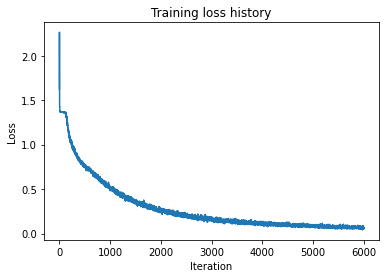

In [98]:
num_epochs = 6000
batch_size = 1191 

# create the RNN_DNN model
rnn_dnn_model = RNN_DNN(
          cell_type='lstm',
          input_dim = 1, 
          input_dim_v = Pointdata_train.shape[1],
          input_dim_t= 50  ,#Seqdata_train.shape[1], 
          proj_dim = 10,
          C=4, 
          hidden_dim = 1, 
          reg = 0.0, 
          dropratio = 0.5, 
          #DNN_hidden_Size=[1024,1024,2048,2048,1024,1024,512,256,256,64], #str0
          #DNN_hidden_Size=[1024,1024,1024,1024, 2048, 512, 512, 512, 512, 512, 512, 256, 256], #str1
          #DNN_hidden_Size=[2048, 1024, 1024, 1024, 512, 512, 512], #str2
          #DNN_hidden_Size=[2048, 1024, 1024, 512, 512],  #str3
          #DNN_hidden_Size=[2048, 1024, 512],  #str4
          #DNN_hidden_Size=[2048, 1024, 16],  #str9
          #DNN_hidden_Size=[256, 1024, 2048, 512, 512],  #str10
          DNN_hidden_Size=[256, 1024, 2048, 1024, 512],  #str11
          **to_float_cuda)

for learning_rate in [1e-3]:
  print('learning rate is: ', learning_rate)
  ModelTrain(rnn_dnn_model, Pointdata_train, Seqdata_train, class_y_train, 
                num_epochs=num_epochs, batch_size=batch_size,
                learning_rate=learning_rate)

### Testing

In [99]:
rnn_dnn_model = rnn_dnn_model.eval()  
y_pred_train = rnn_dnn_model.test_process(Pointdata_train, Seqdata_train).to('cpu')
y_pred_train

y_pred = rnn_dnn_model.test_process(Pointdata_test, Seqdata_test).to('cpu')
y_pred

tensor([0, 1, 1, 2, 2, 2, 3, 1, 1, 3, 2, 2, 0, 2, 1, 3, 1, 2, 0, 1, 2, 1, 2, 0,
        2, 2, 3, 3, 1, 0, 2, 1, 3, 3, 3, 2, 2, 1, 2, 3, 3, 2, 1, 2, 2, 2, 1, 0,
        3, 2, 3, 0, 0, 1, 1, 1, 1, 3, 3, 1, 2, 1, 2, 3, 3, 0, 2, 2, 2, 2, 3, 3,
        3, 3, 3, 1, 3, 2, 3, 2, 1, 3, 3, 3, 2, 2, 1, 3, 0, 2, 2, 3, 2, 1, 3, 1,
        2, 2, 0, 2, 1, 1, 2, 0, 3, 3, 2, 0, 2, 3, 2, 2, 3, 2, 2, 1, 1, 3, 1, 2,
        2, 1, 2, 2, 1, 2, 3, 2, 0, 2, 0, 2, 1, 3, 3, 1, 2, 2, 0, 2, 3, 1, 0, 2,
        2, 2, 2, 1, 1, 3, 0, 2, 0, 3, 1, 2, 1, 1, 0, 2, 3, 2, 2, 0, 3, 0, 0, 2,
        0, 3, 0, 3, 1, 2, 2, 1, 2, 2, 0, 2, 1, 2, 0, 1, 2, 1, 1, 3, 2, 3, 0, 0,
        3, 2, 0, 0, 3, 3, 2, 0, 3, 3, 2, 3, 2, 3, 2, 2, 0, 2, 0, 3, 1, 1, 0, 3,
        0, 2, 2, 2, 2, 0, 2, 0, 2, 3, 3, 1, 1, 3, 1, 0, 2, 1, 0, 1, 2, 2, 0, 2,
        1, 3, 2, 1, 1, 2, 1, 0, 2, 3, 3, 0, 3, 2, 2, 3, 2, 3, 3, 0, 3, 1, 2, 0,
        0, 1, 1, 0, 1, 1, 3, 3, 2, 3, 2, 1, 0, 2, 2, 1, 3, 1, 0, 0, 1, 3, 0, 1,
        1, 1, 2, 3, 3, 2, 2, 3, 1, 0])

In [100]:
from sklearn.metrics import classification_report, confusion_matrix
print('-----------test-------------')
print(confusion_matrix(class_y_test,y_pred))
print(classification_report(class_y_test,y_pred))
print('-----------train-------------')
print(confusion_matrix(class_y_train,y_pred_train))
print(classification_report(class_y_train,y_pred_train))

-----------test-------------
[[ 50   0   0   2]
 [  1  69   2   0]
 [  1   0 101   5]
 [  0   0   0  67]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        52
           1       1.00      0.96      0.98        72
           2       0.98      0.94      0.96       107
           3       0.91      1.00      0.95        67

    accuracy                           0.96       298
   macro avg       0.96      0.97      0.96       298
weighted avg       0.97      0.96      0.96       298

-----------train-------------
[[199   0   0   3]
 [  0 318   3   0]
 [  0   0 359   1]
 [  1   1   0 306]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       202
           1       1.00      0.99      0.99       321
           2       0.99      1.00      0.99       360
           3       0.99      0.99      0.99       308

    accuracy                           0.99      1191
   macro avg       0.99   